# Data Processing
This note book processes, cleans, and repacks the raw data into analysis data files

In [ ]:
### Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as  plt
import json
import yfinance as yf

## Clean & Repack

In [ ]:
# Directory where your CSV files are located
directory = r'E:\\csv'

# List all files in the directory
all_files = os.listdir(directory)

# Filter out only CSV files
csv_files = [file for file in all_files if file.endswith('.csv')]

### csv_files contains more than 560,000 small, raw csv files

In [ ]:
### Extract symbols for each message, produce a symbol list column which is a list of tickers tagged by this message. 

def extract_symbols(symbol_list):
    return [symbol_dict['symbol'] for symbol_dict in symbol_list]


miss = []
c = 0
for i in csv_files[330000:]:
    raw = pd.read_csv(f"E:\\csv\\{i}")

    ## find missing message number
    mn = 1000 - raw.shape[0]
    miss.append({'file':i, "missing":mn})


    mes = raw[['message_id', 'message_body']]
    df = raw.drop(columns=['message_body'])
    df['symbols'] = df['symbols'].fillna("[]")
    df['symbols'] = df['symbols'].apply(json.loads)


    # Apply the function to the 'symbols' column to create a new column 'symbol_list'
    df['symbol_list'] = df['symbols'].apply(extract_symbols)

    # Optionally, you can drop the original 'symbols_str' and 'symbols' columns if you no longer need them
    df.drop(columns=[ 'symbols'], inplace=True)

    df.to_csv(f"E:\\csv_no_mes\\{i}")
    mes.to_csv(f"E:\\csv_mes\\{i}")
    c+=1
    if c %5000 ==0:
        print(str(c)+" files processed")

In [ ]:
### Extract user-labeled  sentiment for each message, produce a sentiment column which could have values = (NaN, 'Bullish', 'Bearish')

def get_sentiment(s):
    if type(s) is str:
        return s[11:18]
    return s


#miss = []
dfs = []
c = 0
for i in csv_files[500000:]:
    df = pd.read_csv(f"E:\\csv_no_mes\\{i}").drop_duplicates(subset='message_id')
    ## find missing message number
    #mn = 1000 - df.shape[0]
    #miss.append({'file':i, "missing":mn})


    df['sentiment'] = df['sentiment'].apply(get_sentiment)
    df.drop(columns=['prices','Unnamed: 0'], inplace=True)

    dfs.append(df)
    c+=1
    if c %10000 ==0:
        print(str(c)+" files processed")

In [ ]:
### Save the repacked csv
big = pd.concat(dfs)
big.to_csv("E:\\data_clean\\no_mes_part_6.csv")

## Make analysis files

### Making no-daytime clean file, the total sizeis around 85% of the data_clean

In [2]:
clean1 = pd.read_csv("E:\\data_clean\\no_mes_part_1.csv")

,Unnamed: 0,message_id,user_id,created_at,sentiment,parent_message_id,in_reply_to_message_id,symbol_list
0,0,4,593,2008-05-27T15:28:28Z,NaN,NaN,NaN,['V']
1,1,5,8687,2008-05-27T16:03:34Z,NaN,NaN,NaN,['NES']
2,2,6,549,2008-05-27T17:48:41Z,NaN,6.0,NaN,['AAPL']
3,3,7,170,2008-05-27T19:11:10Z,NaN,7.0,NaN,['XLE']
4,4,9,126,2008-05-27T22:39:09Z,NaN,NaN,NaN,['AAPL']


In [ ]:
# making no-daytime clean file. 
for i in range(1,7):
    df = pd.read_csv(f"E:\\data_clean\\no_mes_part_{i}.csv").drop(columns=['Unnamed: 0'])
    print('file loaded.')
    df['created_at'] =  [i[:10] for i in df['created_at']]
    print('date modified.')
    df['sentiment'] = df['sentiment'].replace({'Bullish': 1, 'Bearish': -1})
    print('sentiment reformed')
    df['parent_message_id'] = df['parent_message_id'].astype('Int64')
    df['in_reply_to_message_id'] = df['in_reply_to_message_id'].astype('Int64')
    print('mes_id type aligned.')
    # Replace parent_message_id and in_reply_to_message_id with NaN if they are the same as message_id
    df.loc[df['parent_message_id'] == df['message_id'], 'parent_message_id'] = pd.NA
    df.loc[df['in_reply_to_message_id'] == df['message_id'], 'in_reply_to_message_id'] = pd.NA
    print('mes_id reformed')
    df.to_csv(f"E:\\clean_no_time\\no_mes_part_{i}.csv")
    print('file saved. ')

### Making count_by_date file

In [34]:
topath = "E:\\analysis_data"

In [37]:
df = pd.read_csv('E:\\clean_no_time\\no_mes_part_1.csv')[['created_at','message_id','user_id','parent_message_id','in_reply_to_message_id']]
df.head()

,created_at,message_id,user_id,parent_message_id,in_reply_to_message_id
0,2008-05-27,4,593,NaN,NaN
1,2008-05-27,5,8687,NaN,NaN
2,2008-05-27,6,549,NaN,NaN
3,2008-05-27,7,170,NaN,NaN
4,2008-05-27,9,126,NaN,NaN


In [44]:
rlis = []
for i in range(1,7):
    df = pd.read_csv(f'E:\\clean_no_time\\no_mes_part_{i}.csv')[['created_at','message_id','user_id','parent_message_id','in_reply_to_message_id']]
    result = df.groupby('created_at').agg(
    message_id_count=('message_id', 'count'),
    parent_message_id_count=('parent_message_id', 'count'),
    in_reply_to_message_id_count=('in_reply_to_message_id', 'count'),
    unique_user_id_count=('user_id', 'nunique')
).reset_index()
    rlis.append(result)

In [45]:
combined_df = pd.concat(rlis)

# Ensure the date column is in datetime format (optional, if needed)
combined_df['date'] = pd.to_datetime(combined_df['created_at'])
# Group by date and sum the values
big_result_df = combined_df.groupby('date').sum().reset_index()

C:\Users\xl2860\AppData\Local\Temp\20\ipykernel_8808\3176953268.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  big_result_df = combined_df.groupby('date').sum().reset_index()


In [47]:
big_result_df = big_result_df.sort_values(by = 'date')
big_result_df

,date,message_id_count,parent_message_id_count,in_reply_to_message_id_count,unique_user_id_count
0,2008-05-27,5,0,0,5
1,2008-05-28,11,0,0,11
2,2008-05-29,26,0,0,13
3,2008-05-30,29,0,0,17
4,2008-05-31,3,0,0,3
...,...,...,...,...,...
5590,2023-12-29,21080,8906,8906,9892
5591,2023-12-30,4537,2321,2321,2416
5592,2023-12-31,6650,3220,3220,3010
5593,2024-01-01,5505,2437,2438,2894


<Axes: xlabel='date', ylabel='message_id_count'>

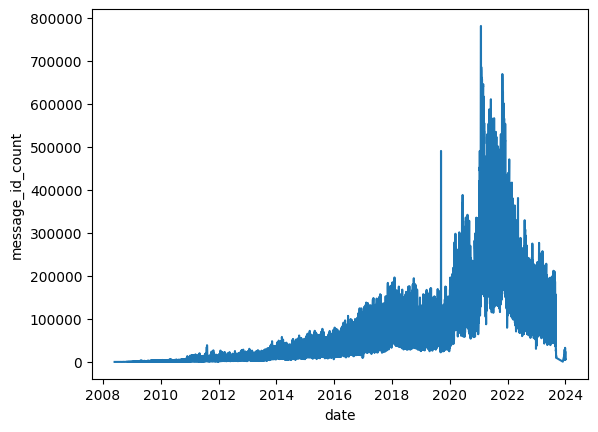

In [48]:
sns.lineplot(data = big_result_df, x = 'date', y = 'message_id_count')

In [52]:
big_result_df.to_csv('E:\\analysis_data\\count_by_date.csv')

### Making have_symbol file

In [66]:
for i in range(1,7):
    df = pd.read_csv(f'E:\\clean_no_time\\no_mes_part_{i}.csv').drop(columns = ['Unnamed: 0','parent_message_id','in_reply_to_message_id'])
    print(f"for part {i}")
    print(f'original shape: {df.shape}')

    use1 = df.loc[df['symbol_list'] != '[]']
    use1.to_csv(f"E:\\analysis_data\\have_symbol\\part_{i}.csv")
    print(f'have symbol shape: {use1.shape}')

    use2 = use1.loc[use1['sentiment'].notna()]
    use2.to_csv(f"E:\\analysis_data\\have_symbol_sentiment\\part_{i}.csv")
    print(f'have symbol and sentiment shape: {use2.shape}')


    use3 = df.loc[df['sentiment'].notna()]
    use3.to_csv(f"E:\\analysis_data\\have_sentiment\\part_{i}.csv")
    print(f'have sentiment shape: {use3.shape}')

for part 1
original shape: (95188749, 5)
have symbol shape: (49336814, 5)
have symbol and sentiment shape: (18212058, 5)
have sentiment shape: (27799302, 5)
for part 2
original shape: (88639165, 5)
have symbol shape: (43882251, 5)
have symbol and sentiment shape: (20287630, 5)
have sentiment shape: (31671162, 5)
for part 3
original shape: (86651214, 5)
have symbol shape: (44868352, 5)
have symbol and sentiment shape: (22973400, 5)
have sentiment shape: (35861788, 5)
for part 4
original shape: (96060583, 5)
have symbol shape: (49898213, 5)
have symbol and sentiment shape: (25371003, 5)
have sentiment shape: (39212683, 5)
for part 5
original shape: (87757046, 5)
have symbol shape: (48325043, 5)
have symbol and sentiment shape: (20538047, 5)
have sentiment shape: (29937859, 5)
for part 6
original shape: (47145533, 5)
have symbol shape: (25814839, 5)
have symbol and sentiment shape: (7855256, 5)
have sentiment shape: (11320364, 5)


for part 1\\
original shape: (95188749, 5)\\
have symbol shape: (49336814, 5)\\
have symbol and sentiment shape: (18212058, 5)\\
have sentiment shape: (27799302, 5)\\
for part 2\\
original shape: (88639165, 5)
have symbol shape: (43882251, 5)
have symbol and sentiment shape: (20287630, 5)
have sentiment shape: (31671162, 5)
for part 3
original shape: (86651214, 5)
have symbol shape: (44868352, 5)
have symbol and sentiment shape: (22973400, 5)
have sentiment shape: (35861788, 5)
for part 4
original shape: (96060583, 5)
have symbol shape: (49898213, 5)
have symbol and sentiment shape: (25371003, 5)
have sentiment shape: (39212683, 5)
for part 5
original shape: (87757046, 5)
have symbol shape: (48325043, 5)
have symbol and sentiment shape: (20538047, 5)
have sentiment shape: (29937859, 5)
for part 6
original shape: (47145533, 5)
have symbol shape: (25814839, 5)
have symbol and sentiment shape: (7855256, 5)
have sentiment shape: (11320364, 5

### Making mes_date file and missing message number file

In [3]:
dfs = []
for i in range(1,7):
    sub = pd.read_csv(f"E:\\clean_no_time\\no_mes_part_{i}.csv")[['message_id','created_at']]
    dfs.append(sub)
    print(f"no_mes_part_{i}.csv done")
sub = ''
big = pd.concat(dfs)
dfs = ''

no_mes_part_1.csv done
no_mes_part_2.csv done
no_mes_part_3.csv done
no_mes_part_4.csv done
no_mes_part_5.csv done
no_mes_part_6.csv done


In [21]:
# big = big.sort_values(by = ['created_at','message_id'])
# big.head()
big = pd.read_csv("E:\\analysis_data\\mes_date.csv")

In [22]:
### strange ones
big['message_diff'] = big['message_id'].diff()
check = big.loc[(big['created_at']<='2022-12-31')&(big['message_diff']<0)]

In [28]:
check.head(106)

,Unnamed: 0,message_id,created_at,message_diff
1573211,13740302,2029053,2010-10-27,-26711.0
2352761,9703148,2900105,2011-02-19,-1036.0
37910172,43892853,41096581,2015-08-11,-5.0
38043013,45425648,41240721,2015-08-13,-2.0
38185262,47088937,41397736,2015-08-17,-1.0
...,...,...,...,...
85505734,38501771,91727707,2017-08-11,-3.0
85905915,38946124,92151938,2017-08-16,-2.0
86162981,39230883,92423172,2017-08-18,-2.0
164216099,78413458,174207884,2019-08-15,-1.0


In [5]:
big['message_diff'] = big['message_id'].diff()
use = big.loc[(big['created_at']<='2022-12-31')&(big['message_diff']>0)&(big['message_diff']<10)]
use['missing_btw'] = use['message_diff'] - 1

C:\Users\xl2860\AppData\Local\Temp\22\ipykernel_2056\2250582362.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use['missing_btw'] = use['message_diff'] - 1


In [17]:
use1['month'] = [pd.to_datetime(i[:7]) for i in use1['created_at']]
use1.head()

,created_at,missing_btw,month
0,2008-05-27,1.0,2008-05-01
1,2008-05-28,15.0,2008-05-01
2,2008-05-29,20.0,2008-05-01
3,2008-05-30,15.0,2008-05-01
4,2008-05-31,0.0,2008-05-01


In [16]:
use1.to_csv("E:\\analysis_data\\miss_by_date.csv")

In [18]:
use2 = use1[['month','missing_btw']].groupby(by = 'month').sum().reset_index()
use2.head()

,month,missing_btw
0,2008-05-01,51.0
1,2008-06-01,431.0
2,2008-07-01,570.0
3,2008-08-01,537.0
4,2008-09-01,1187.0


<Axes: xlabel='month', ylabel='missing_btw'>

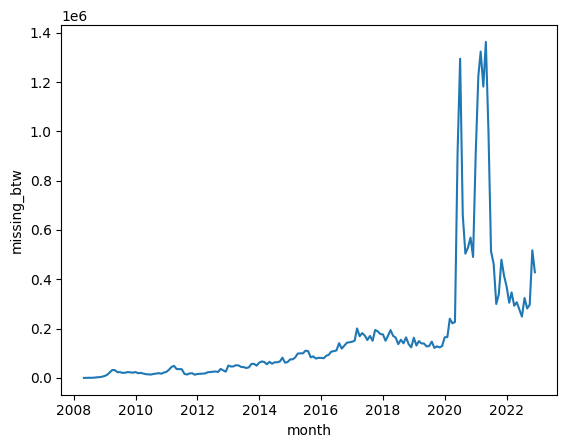

In [19]:
sns.lineplot(data = use2, x = 'month',y = 'missing_btw')

In [10]:
#big.to_csv("E:\\analysis_data\\mes_date.csv")

In [11]:
big.shape

(501442290, 3)

In [12]:
big = big.loc[big['created_at']<='2022-12-31']

In [16]:
strange = big.loc[(big['message_diff'] >= 10)]
strange

,Unnamed: 0,message_id,created_at,message_diff
293,293,443,2008-06-09,11.0
344,344,535,2008-06-10,15.0
385,385,602,2008-06-11,10.0
815,815,1347,2008-07-01,14.0
1071,1071,1797,2008-07-14,10.0
...,...,...,...,...
464414784,46109492,504028204,2022-12-31,11.0
464415038,46109745,504028612,2022-12-31,10.0
464418321,46113994,504032610,2022-12-31,10.0
464418503,46114176,504032830,2022-12-31,11.0


<Axes: xlabel='message_diff', ylabel='Count'>

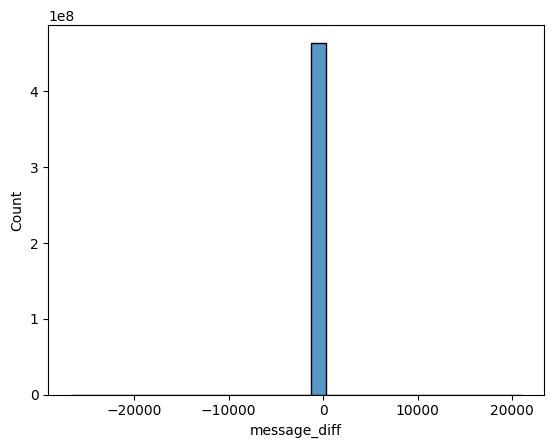

In [14]:
sns.histplot(data = big, x = 'message_diff')

<Axes: xlabel='message_diff', ylabel='Count'>

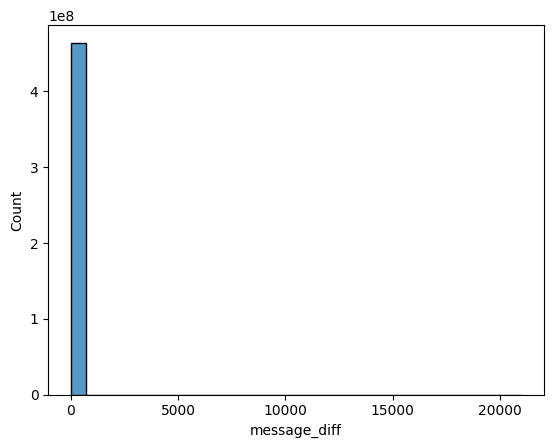

In [15]:
sns.histplot(data = big.loc[big['message_diff']>0], x = 'message_diff')

In [18]:
check = big.loc[big['created_at'] == '2010-10-27']

In [19]:
check

,message_id,created_at,message_diff
13740302,2029053,2010-10-27,-26711.0
13740303,2029054,2010-10-27,1.0
13740304,2029055,2010-10-27,1.0
13740305,2029056,2010-10-27,1.0
13740306,2029057,2010-10-27,1.0
...,...,...,...
14378271,2035440,2010-10-27,1.0
14378272,2035441,2010-10-27,1.0
14378273,2035442,2010-10-27,1.0
14378274,2035443,2010-10-27,1.0


In [23]:
check2 = big.reset_index().loc[big['created_at'] == '2010-10-26']

In [ ]:
check2.tail(20)

,message_id,created_at,message_diff
13740287,2029035,2010-10-26,1.0
13740288,2029036,2010-10-26,1.0
13740289,2029037,2010-10-26,1.0
13740290,2029038,2010-10-26,1.0
13740291,2029039,2010-10-26,1.0
13740292,2029040,2010-10-26,1.0
13740293,2029041,2010-10-26,1.0
13740294,2029042,2010-10-26,1.0
13740295,2029043,2010-10-26,1.0
13740296,2029045,2010-10-26,2.0


### Check missing and total message_count

In [4]:
miss = pd.read_csv("E:\\analysis_data\\miss_by_date.csv").drop(columns = 'Unnamed: 0')
cnt = pd.read_csv("E:\\analysis_data\\count_by_date.csv").drop(columns = 'Unnamed: 0')

In [5]:
use = miss.merge(cnt, left_on = 'created_at',right_on = 'date')

In [6]:
use['date'] = pd.to_datetime(use['date'])

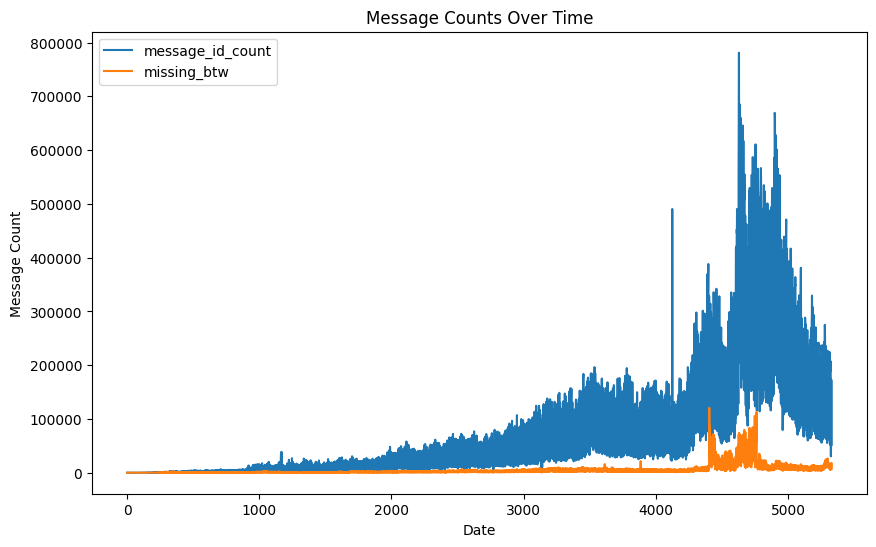

In [41]:
# Set 'date' as the index for easier plotting
# use.set_index('date', inplace=True)

# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(use.index, use['message_id_count'], label='message_id_count', marker='')
#plt.plot(use.index, use['parent_message_id_count'], label='parent_message_id_count', marker='')
#plt.plot(use.index, use['in_reply_to_message_id_count'], label='in_reply_to_message_id_count', marker='')
plt.plot(use.index, use['missing_btw'], label='missing_btw', marker='')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Message Count')
plt.title('Message Counts Over Time')
plt.legend()

# Display the plot
plt.show()

In [7]:
use1 = use.reset_index()[['month','missing_btw','message_id_count','parent_message_id_count','in_reply_to_message_id_count']]
use1['month'] = pd.to_datetime(use1['month'])
use2 = use1.groupby(by = 'month').sum()
use = use2

In [8]:
use2.head()

,missing_btw,message_id_count,parent_message_id_count,in_reply_to_message_id_count
month,,,,
2008-05-01,51.0,74,0,0
2008-06-01,431.0,741,0,0
2008-07-01,570.0,895,0,0
2008-08-01,537.0,1074,0,0
2008-09-01,1187.0,3315,0,0


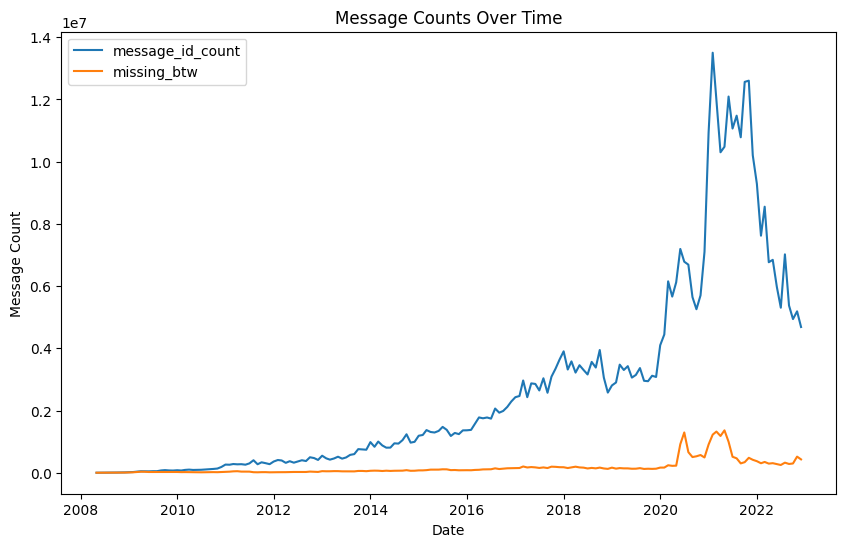

In [44]:
# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(use.index, use['message_id_count'], label='message_id_count', marker='')
#plt.plot(use.index, use['parent_message_id_count'], label='parent_message_id_count', marker='')
#plt.plot(use.index, use['in_reply_to_message_id_count'], label='in_reply_to_message_id_count', marker='')
plt.plot(use.index, use['missing_btw'], label='missing_btw', marker='')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Message Count')
plt.title('Message Counts Over Time')
plt.legend()

# Display the plot
plt.show()

In [46]:
use.head()

,missing_btw,message_id_count,parent_message_id_count,in_reply_to_message_id_count
month,,,,
2008-05-01,51.0,74,0,0
2008-06-01,431.0,741,0,0
2008-07-01,570.0,895,0,0
2008-08-01,537.0,1074,0,0
2008-09-01,1187.0,3315,0,0


In [9]:
use['miss_rate'] = use['missing_btw']/(use['message_id_count']+ use['missing_btw'])
use.head()

,missing_btw,message_id_count,parent_message_id_count,in_reply_to_message_id_count,miss_rate
month,,,,,
2008-05-01,51.0,74,0,0,0.408000
2008-06-01,431.0,741,0,0,0.367747
2008-07-01,570.0,895,0,0,0.389078
2008-08-01,537.0,1074,0,0,0.333333
2008-09-01,1187.0,3315,0,0,0.263661


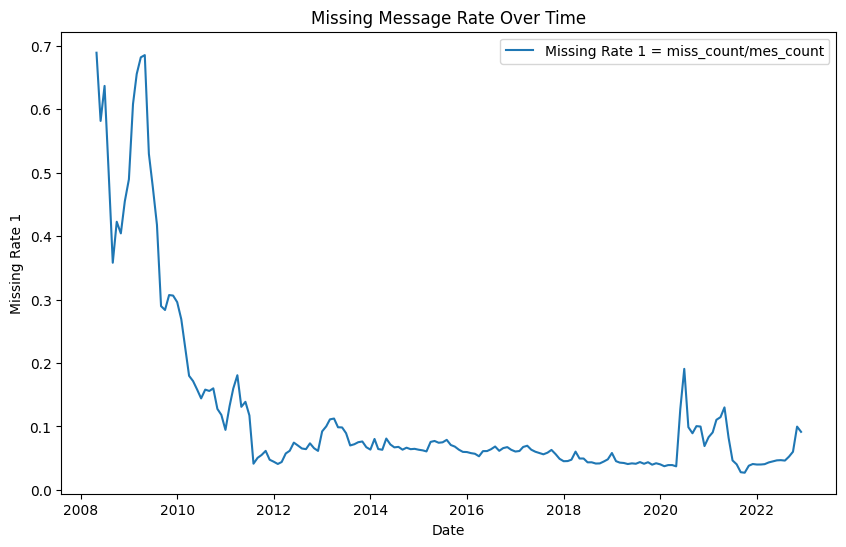

In [50]:
# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(use.index, use['miss_rate'], label='Missing Rate 1 = miss_count/mes_count', marker='')
#plt.plot(use.index, use['parent_message_id_count'], label='parent_message_id_count', marker='')
#plt.plot(use.index, use['in_reply_to_message_id_count'], label='in_reply_to_message_id_count', marker='')
#plt.plot(use.index, use['missing_btw'], label='missing_btw', marker='')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Missing Rate 1')
plt.title('Missing Message Rate Over Time')
plt.legend()

# Display the plot
plt.show()

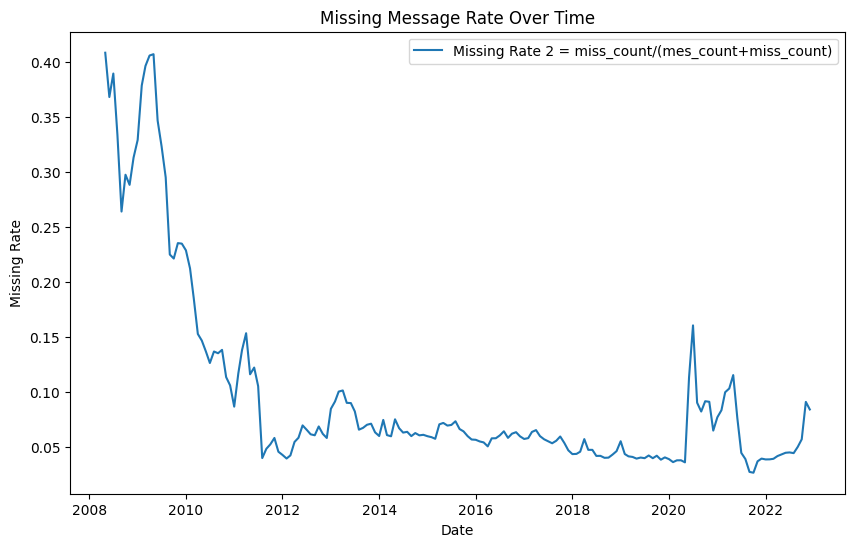

In [10]:
# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(use.index, use['miss_rate'], label='Missing Rate 2 = miss_count/(mes_count+miss_count)', marker='')
#plt.plot(use.index, use['parent_message_id_count'], label='parent_message_id_count', marker='')
#plt.plot(use.index, use['in_reply_to_message_id_count'], label='in_reply_to_message_id_count', marker='')
#plt.plot(use.index, use['missing_btw'], label='missing_btw', marker='')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Missing Rate')
plt.title('Missing Message Rate Over Time')
plt.legend()

# Display the plot
plt.show()

### Making have symbol and have sentiemnt file

In [2]:
dfs = []
for i in range(1,7):
    df = pd.read_csv(f'E:\\analysis_data\\have_sentiment\\part_{i}.csv').drop(columns = ['Unnamed: 0'])
    df = df.loc[df['created_at']<='2022-12-31']
    dfs.append(df)
    print(f'part_{i}.csv added')
big = pd.concat(dfs)
dfs = ''
big.to_csv('E:\\analysis_data\\have_sentiment_big.csv')

part_1.csv added
part_2.csv added
part_3.csv added
part_4.csv added
part_5.csv added
part_6.csv added


In [2]:
dfs = []
for i in range(1,7):
    df = pd.read_csv(f'E:\\analysis_data\\have_symbol\\part_{i}.csv').drop(columns = ['Unnamed: 0'])
    df = df.loc[df['created_at']<='2022-12-31']
    dfs.append(df)
    print(f'part_{i}.csv added')
big = pd.concat(dfs)
dfs = ''
big.to_csv('E:\\analysis_data\\have_symbol_big.csv')

part_1.csv added
part_2.csv added
part_3.csv added
part_4.csv added
part_5.csv added
part_6.csv added


In [2]:
dfs = []
for i in range(1,7):
    df = pd.read_csv(f'E:\\analysis_data\\have_symbol_sentiment\\part_{i}.csv').drop(columns = ['Unnamed: 0'])
    df = df.loc[df['created_at']<='2022-12-31']
    dfs.append(df)
    print(f'part_{i}.csv added')
big = pd.concat(dfs)
dfs = ''
big.to_csv('E:\\analysis_data\\have_symbol_sentimnet_big.csv')

part_1.csv added
part_2.csv added
part_3.csv added
part_4.csv added
part_5.csv added
part_6.csv added
